# **Outlier Detection using PYSPARK**

---



---



### Installing the PYSPARK module

In [ ]:
!pip install pyspark

### Mounting the google drive datasets

In [ ]:
from google.colab import drive
drive.mount('/content/datasets')

Drive already mounted at /content/datasets; to attempt to forcibly remount, call drive.mount("/content/datasets", force_remount=True).


In [ ]:
# This code creates a filterable and interactive data table like excel for pandas dataframes
from google.colab import data_table
data_table.enable_dataframe_formatter()

### Importing the necessary libraries

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession


### Creating a Spark Session

In [ ]:
spark = SparkSession.builder.appName('OUTLIER REMOVAL').getOrCreate()
spark

### Reading the dataset from Google Drive using spark session

In [ ]:
df = spark.read.csv('/content/datasets/MyDrive/Datasets/UCLA_Module2_FinalProject/customer_data.csv',header = True)
df.show()

+-------+------+-----+-----+-------+------+----------------+------------+
|Channel|Region|Fresh| Milk|Grocery|Frozen|Detergents_Paper|Delicatessen|
+-------+------+-----+-----+-------+------+----------------+------------+
|      2|     3|12669| 9656|   7561|   214|            2674|        1338|
|      2|     3| 7057| 9810|   9568|  1762|            3293|        1776|
|      2|     3| 6353| 8808|   7684|  2405|            3516|        7844|
|      1|     3|13265| 1196|   4221|  6404|             507|        1788|
|      2|     3|22615| 5410|   7198|  3915|            1777|        5185|
|      2|     3| 9413| 8259|   5126|   666|            1795|        1451|
|      2|     3|12126| 3199|   6975|   480|            3140|         545|
|      2|     3| 7579| 4956|   9426|  1669|            3321|        2566|
|      1|     3| 5963| 3648|   6192|   425|            1716|         750|
|      2|     3| 6006|11093|  18881|  1159|            7425|        2098|
|      2|     3| 3366| 5403|  12974|  

### Counting the number of records

In [ ]:
df.count()

440

### Checking the number of columns

In [ ]:
len(df.columns)

8

### Printing the schema, to check the datatypes

1. All the features are of string data type
1. The columns `Channel` & `Region` are categorical features
1. Other columns are to be converted into numerical data types

In [ ]:
df.printSchema()

root
 |-- Channel: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Fresh: string (nullable = true)
 |-- Milk: string (nullable = true)
 |-- Grocery: string (nullable = true)
 |-- Frozen: string (nullable = true)
 |-- Detergents_Paper: string (nullable = true)
 |-- Delicatessen: string (nullable = true)



### Segregating the desired columns to convert the data type ino IntegerType

In [ ]:
numeric_cols = df.columns[2:]
numeric_cols

['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']

In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType

In [ ]:
for column in numeric_cols:
    df = df.withColumn(column,f.col(column).cast(IntegerType()))


### Checking the schema after converting the numerical columns into IntegerType

In [ ]:
df.printSchema()

root
 |-- Channel: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Fresh: integer (nullable = true)
 |-- Milk: integer (nullable = true)
 |-- Grocery: integer (nullable = true)
 |-- Frozen: integer (nullable = true)
 |-- Detergents_Paper: integer (nullable = true)
 |-- Delicatessen: integer (nullable = true)



### Creating a variable to store all the numerical columns into a list

In [ ]:
numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']
numeric_columns

['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']

### Creating a customized function 

1. 

In [ ]:
def find_outliers(df):

    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_cols:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,f.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',sum(df[column] for column in selected_columns))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df
    

### Using the customized Outlier function and applying it to a spark dataframe

In [ ]:
new_df = find_outliers(df)
new_df.show()



+-------+------+-----+-----+-------+------+----------------+------------+--------------+
|Channel|Region|Fresh| Milk|Grocery|Frozen|Detergents_Paper|Delicatessen|total_outliers|
+-------+------+-----+-----+-------+------+----------------+------------+--------------+
|      2|     3|12669| 9656|   7561|   214|            2674|        1338|             0|
|      2|     3| 7057| 9810|   9568|  1762|            3293|        1776|             0|
|      2|     3| 6353| 8808|   7684|  2405|            3516|        7844|             1|
|      1|     3|13265| 1196|   4221|  6404|             507|        1788|             0|
|      2|     3|22615| 5410|   7198|  3915|            1777|        5185|             1|
|      2|     3| 9413| 8259|   5126|   666|            1795|        1451|             0|
|      2|     3|12126| 3199|   6975|   480|            3140|         545|             0|
|      2|     3| 7579| 4956|   9426|  1669|            3321|        2566|             0|
|      1|     3| 5963

### Fitering the above dataframe, to select only those records where the outlier count is < = 1

In [ ]:
new_df_with_no_outliers = new_df.filter(new_df['total_Outliers']<=1)
new_df_with_no_outliers = new_df_with_no_outliers.select(*df.columns)

new_df_with_no_outliers.show()

+-------+------+-----+-----+-------+------+----------------+------------+
|Channel|Region|Fresh| Milk|Grocery|Frozen|Detergents_Paper|Delicatessen|
+-------+------+-----+-----+-------+------+----------------+------------+
|      2|     3|12669| 9656|   7561|   214|            2674|        1338|
|      2|     3| 7057| 9810|   9568|  1762|            3293|        1776|
|      2|     3| 6353| 8808|   7684|  2405|            3516|        7844|
|      1|     3|13265| 1196|   4221|  6404|             507|        1788|
|      2|     3|22615| 5410|   7198|  3915|            1777|        5185|
|      2|     3| 9413| 8259|   5126|   666|            1795|        1451|
|      2|     3|12126| 3199|   6975|   480|            3140|         545|
|      2|     3| 7579| 4956|   9426|  1669|            3321|        2566|
|      1|     3| 5963| 3648|   6192|   425|            1716|         750|
|      2|     3| 6006|11093|  18881|  1159|            7425|        2098|
|      2|     3| 3366| 5403|  12974|  

### The count of the dataframe, after removing the outliers

In [ ]:
new_df_with_no_outliers.count()

399

### The dataset, which contains 2 or more outliers in each record

In [ ]:
data_with_outliers = new_df.filter(new_df['total_Outliers']>=2)
data_with_outliers.show()

+-------+------+-----+-----+-------+------+----------------+------------+--------------+
|Channel|Region|Fresh| Milk|Grocery|Frozen|Detergents_Paper|Delicatessen|total_outliers|
+-------+------+-----+-----+-------+------+----------------+------------+--------------+
|      1|     3|31276| 1917|   4469|  9408|            2381|        4334|             2|
|      2|     3|26373|36423|  22019|  5154|            4337|       16523|             2|
|      2|     3| 4113|20484|  25957|  1158|            8604|        5206|             3|
|      1|     3|56159|  555|    902| 10002|             212|        2916|             2|
|      1|     3|24025| 4332|   4757|  9510|            1145|        5864|             2|
|      2|     3|  630|11095|  23998|   787|            9529|          72|             2|
|      2|     3| 5181|22044|  21531|  1740|            7353|        4985|             2|
|      2|     3|44466|54259|  55571|  7782|           24171|        6465|             6|
|      2|     3| 4967

In [ ]:
# Selecting the numerical columns from the original dataframe and converting into pandas

numeric_columns

['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']

### Converting a spark dataframe into pandas dataframe, which enables us to plot the graphs using seaborn and matplotlib

In [ ]:
original_numerical_df = df.select(*numeric_columns).toPandas()

original_numerical_df.head(10)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
5,9413,8259,5126,666,1795,1451
6,12126,3199,6975,480,3140,545
7,7579,4956,9426,1669,3321,2566
8,5963,3648,6192,425,1716,750
9,6006,11093,18881,1159,7425,2098


In [ ]:
# Plotting the box for the dataset after removing the outliers

dataset_after_removing_outliers = new_df_with_no_outliers.toPandas()
dataset_after_removing_outliers.head(10)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


In [ ]:
numeric_columns

['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']

### Plotting the box plot, to check the outliers in the original dataframe., and comaring it with the new dataframe after removing outliers

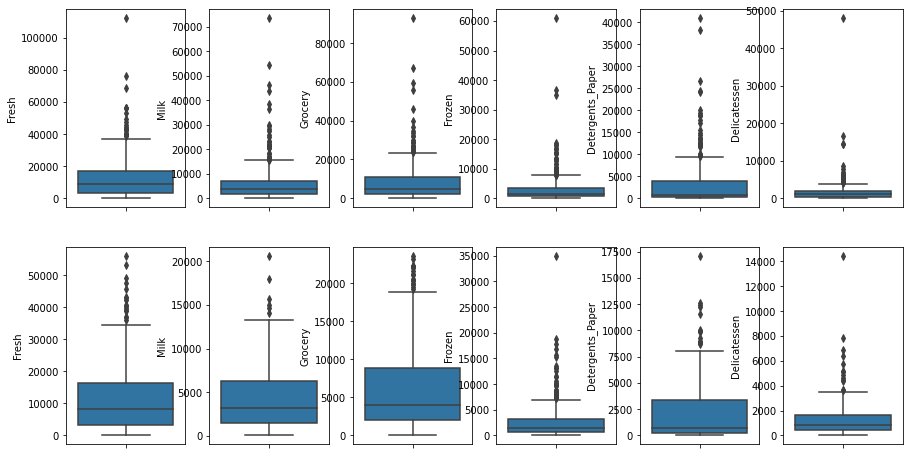

In [ ]:
fig,ax = plt.subplots(2,6,figsize=(15,8))
for i,df in enumerate([original_numerical_df,dataset_after_removing_outliers]):
  
    for j, col in enumerate(numeric_columns):
        sns.boxplot(data = df, y=col,ax=ax[i][j])

### Conclusion / Observations :

1. The initial dataset contains 440 records with `8` features
2. There are total `6` numerical features & `2` categorical features
3. The original spark dataframe has the datatypes of strings
4. The numerical features were converted into IntegerType using cast function
5. Created a customized function to identify outliers in each record
6. Applyng the above customized function, enables us to identify total outliers in each record, based on each feature
7. Filtering the dataset based on the total outliers which are <=1, to eliminate the records with more than 2 outliers
8. The new dataframe, contains `399` records after removing the outliers against `440` records in the inital data frame
9. Comparing the outliers from the original dataset to the new dataset after outlier removal using a box plot
10. There are still some outliers available in the dataset., even after removing majority of the outliers.
11. This shows that the data is skewed, however, the majority of the outliers are removed

